     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 39.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


分析中: 入院_主訴
分析中: 入院_家族背景
分析中: 入院_社会背景
分析中: 入院_現病歴
分析中: 入院_精神医学的現症
分析中: 退院_入院後経過
分析中: 退院_検査所見


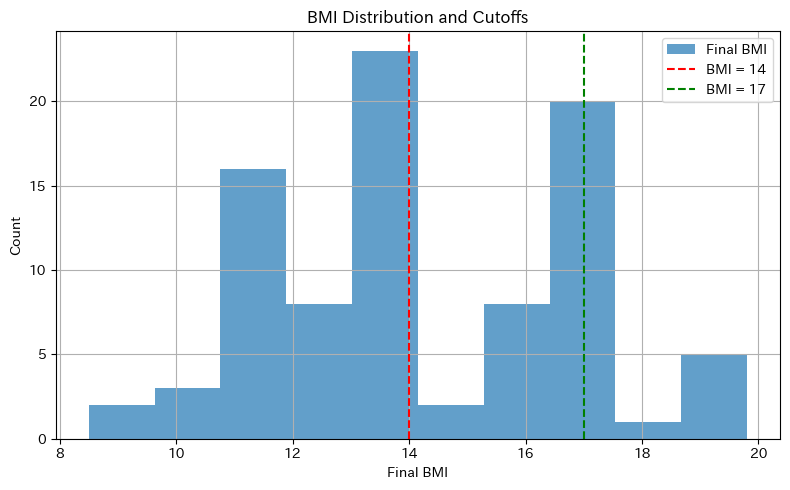

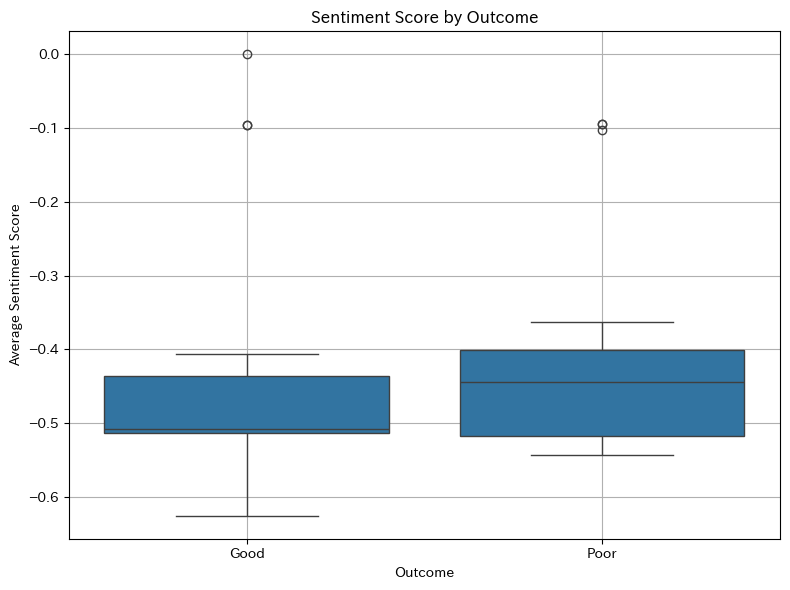

✅ 感情分析 + BMI予後分類の処理が完了しました！


In [4]:
# -*- coding: utf-8 -*-
"""医療データの総合分析 v2: 感情スコアとBMIに基づく予後2群分類（再構成版）"""

# 必要なライブラリをインストール・インポート
!pip install --quiet transformers fugashi unidic-lite ipadic japanize-matplotlib matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from transformers import pipeline
import japanize_matplotlib

plt.rcParams['font.family'] = 'IPAexGothic'

# === ファイルパス設定（Google Drive） ===
summary_file_path = '/content/drive/MyDrive/summary_processed.xlsx'
weight_files_path = '/content/drive/MyDrive/体重改/*_standardized.xlsx'

# === サマリーデータ読み込み ===
df = pd.read_excel(summary_file_path)
df['ID'] = df['ID'].astype(str).str.split('.').str[0]

# === 体重データ読み込みと整形 ===
weight_files = glob.glob(weight_files_path)
weight_data = {}

for filepath in weight_files:
    filename = filepath.split('/')[-1]
    patient_id = filename.split('_')[0]
    df_weight = pd.read_excel(filepath)
    if 'BMI' in df_weight.columns:
        weight_data[patient_id] = {
            'initial_bmi': df_weight['BMI'].iloc[0],
            'final_bmi': df_weight['BMI'].iloc[-1],
            'days': len(df_weight)
        }

bmi_df = pd.DataFrame.from_dict(weight_data, orient='index')
bmi_df.index.name = 'ID'
bmi_df.reset_index(inplace=True)
bmi_df['ID'] = bmi_df['ID'].astype(str)

# === 感情分析 ===
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cl-tohoku/bert-base-japanese-v3",
    tokenizer="cl-tohoku/bert-base-japanese-v3"
)

def analyze_sentiment(text):
    if pd.isna(text):
        return 0
    try:
        result = sentiment_analyzer(text[:512])[0]
        return result['score'] if result['label'] == 'positive' else -result['score']
    except:
        return 0

text_sections = [
    '入院_主訴', '入院_家族背景', '入院_社会背景',
    '入院_現病歴', '入院_精神医学的現症',
    '退院_入院後経過', '退院_検査所見'
]

section_labels_en = {
    '入院_主訴': 'Chief Complaint',
    '入院_家族背景': 'Family History',
    '入院_社会背景': 'Social Background',
    '入院_現病歴': 'Present Illness',
    '入院_精神医学的現症': 'Mental State',
    '退院_入院後経過': 'Hospital Course',
    '退院_検査所見': 'Test Results'
}

sentiment_results = pd.DataFrame()
for section in text_sections:
    print(f"分析中: {section}")
    sentiment_results[section_labels_en[section]] = df[section].apply(analyze_sentiment)

sentiment_results['ID'] = df['ID']

# === データマージ ===
df = df.merge(bmi_df, on='ID', how='left', suffixes=('', '_bmi'))
df = df.merge(sentiment_results, on='ID', how='left', suffixes=('', '_sent'))

# === 欠損値処理 ===
df = df.dropna(subset=['final_bmi'])

# === 予後2群分類 ===
def classify_outcome(bmi):
    return 'Good' if bmi >= 14 else 'Poor'

df['Outcome'] = df['final_bmi'].apply(classify_outcome)

# === BMI分布の可視化 ===
plt.figure(figsize=(8,5))
plt.hist(df['final_bmi'], bins=10, alpha=0.7, label='Final BMI')
plt.axvline(x=14.0, color='r', linestyle='--', label='BMI = 14')
plt.axvline(x=17.0, color='g', linestyle='--', label='BMI = 17')
plt.legend()
plt.xlabel('Final BMI')
plt.ylabel('Count')
plt.title('BMI Distribution and Cutoffs')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 感情スコアと予後の関係 ===
sent_cols = list(section_labels_en.values())
df['Avg Sentiment'] = df[sent_cols].mean(axis=1)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Outcome', y='Avg Sentiment')
plt.title('Sentiment Score by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# 終了メッセージ
print("✅ 感情分析 + BMI予後分類の処理が完了しました！")

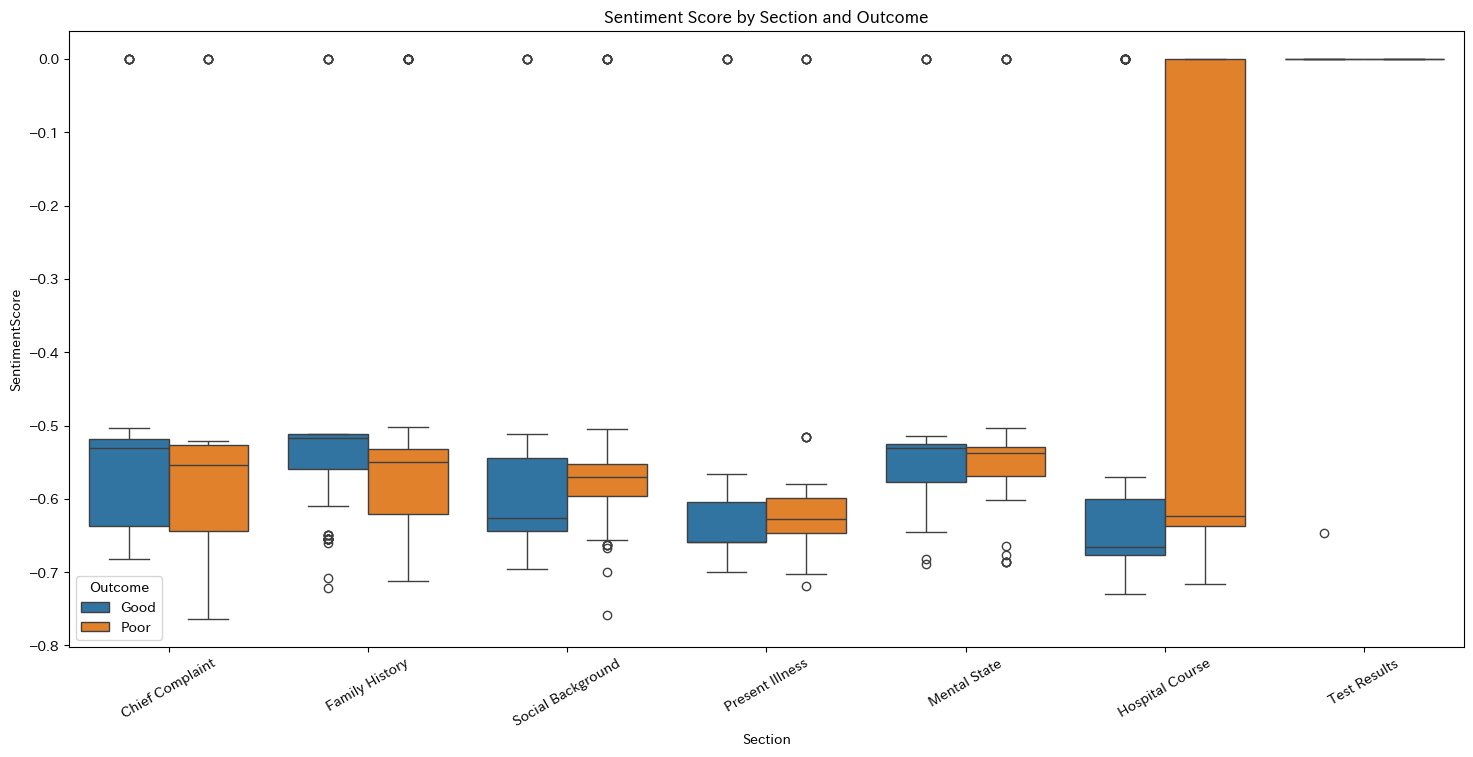


=== 統計検定: 年齢層 × セクションごとの予後差（Mann-Whitney U検定） ===

--- Age Group: 40s ---

--- Age Group: 50s ---
Chief Complaint: p = 0.000
Family History: p = 0.762
Social Background: p = 0.006
Present Illness: p = 0.001
Mental State: p = 0.334
Hospital Course: p = 0.001
Test Results: p = 1.000

--- Age Group: 20s ---
Chief Complaint: p = 0.088
Family History: p = 0.000
Social Background: p = 0.001
Present Illness: p = 0.001
Mental State: p = 0.548
Hospital Course: p = 0.238
Test Results: p = 1.000

--- Age Group: <20 ---
Chief Complaint: p = 0.005
Family History: p = 0.129
Social Background: p = 0.198
Present Illness: p = 0.576
Mental State: p = 0.022
Hospital Course: p = 0.007
Test Results: p = 0.571

--- Age Group: 30s ---


In [7]:
# 年齢層を分類（なければ作る）
if 'AgeGroup' not in df.columns:
    df['AgeGroup'] = pd.cut(df['年齢'].astype(float), bins=[0, 20, 30, 40, 50, 60, 100],
                            labels=['<20', '20s', '30s', '40s', '50s', '60+'])

# 感情スコアとマージ → Melt
melted = df[['ID', 'Outcome', 'AgeGroup']].merge(sentiment_results, on='ID')
melted = pd.melt(melted, id_vars=['ID', 'Outcome', 'AgeGroup'],
                 var_name='Section', value_name='SentimentScore')

# ボックスプロットで可視化
plt.figure(figsize=(18, 8))
sns.boxplot(data=melted, x='Section', y='SentimentScore', hue='Outcome')
plt.title('Sentiment Score by Section and Outcome')
plt.xticks(rotation=30)
plt.legend(title='Outcome')
plt.show()

# 年齢層・セクションごとにMann-Whitney U検定
from scipy.stats import mannwhitneyu

print("\n=== 統計検定: 年齢層 × セクションごとの予後差（Mann-Whitney U検定） ===")
for age in melted['AgeGroup'].unique():
    print(f"\n--- Age Group: {age} ---")
    sub = melted[melted['AgeGroup'] == age]
    for section in sub['Section'].unique():
        good = sub[(sub['Section'] == section) & (sub['Outcome'] == 'Good')]['SentimentScore']
        poor = sub[(sub['Section'] == section) & (sub['Outcome'] == 'Poor')]['SentimentScore']
        if len(good) > 2 and len(poor) > 2:
            stat, p = mannwhitneyu(good, poor, alternative='two-sided')
            print(f"{section}: p = {p:.3f}")


In [45]:
# 和名 → 英語名にリネームして整える
rename_dict = {
    '入院_主訴': 'Chief Complaint',
    '入院_家族背景': 'Family History',
    '入院_社会背景': 'Social Background',
    '入院_現病歴': 'Present Illness',
    '入院_精神医学的現症': 'Mental State',
    '退院_入院後経過': 'Hospital Course',
    '退院_検査所見': 'Test Results'
}
sentiment_results = sentiment_results.rename(columns=rename_dict)
sentiment_columns = list(rename_dict.values())  # ＝ 上の英語名一覧


for group in df['AgeGroup'].dropna().unique():
    for section in sentiment_columns:
        subset = melted[(melted['AgeGroup'] == group) & (melted['Section'] == section)]
        print(f"Checking: AgeGroup={group}, Section={section}, Rows={len(subset)}")


Checking: AgeGroup=40s, Section=Chief Complaint, Rows=5
Checking: AgeGroup=40s, Section=Family History, Rows=5
Checking: AgeGroup=40s, Section=Social Background, Rows=5
Checking: AgeGroup=40s, Section=Present Illness, Rows=5
Checking: AgeGroup=40s, Section=Mental State, Rows=5
Checking: AgeGroup=40s, Section=Hospital Course, Rows=5
Checking: AgeGroup=40s, Section=Test Results, Rows=5
Checking: AgeGroup=50s, Section=Chief Complaint, Rows=19
Checking: AgeGroup=50s, Section=Family History, Rows=19
Checking: AgeGroup=50s, Section=Social Background, Rows=19
Checking: AgeGroup=50s, Section=Present Illness, Rows=19
Checking: AgeGroup=50s, Section=Mental State, Rows=19
Checking: AgeGroup=50s, Section=Hospital Course, Rows=19
Checking: AgeGroup=50s, Section=Test Results, Rows=19
Checking: AgeGroup=20s, Section=Chief Complaint, Rows=48
Checking: AgeGroup=20s, Section=Family History, Rows=48
Checking: AgeGroup=20s, Section=Social Background, Rows=48
Checking: AgeGroup=20s, Section=Present Illness

In [46]:
import statsmodels.api as sm
from scipy.stats import ttest_ind

# === データマージ ===
df = df.merge(bmi_df, on='ID', how='left', suffixes=('', '_bmi'))
df = df.merge(sentiment_results, on='ID', how='left', suffixes=('', '_sent'))

# === 欠損値処理 ===
df = df.dropna(subset=['final_bmi'])

# Rename 'days_bmi' to 'DaysInHospital'
df = df.rename(columns={'days_bmi': 'DaysInHospital'})

# === 予後2群分類 ===
def classify_outcome(bmi):
    return 'Good' if bmi >= 14 else 'Poor'

df['Outcome'] = df['final_bmi'].apply(classify_outcome)



In [79]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# === 対象のセクション ===
sentiment_columns = [
    'Chief Complaint', 'Family History', 'Social Background',
    'Present Illness', 'Mental State', 'Hospital Course', 'Test Results'
]

# === 予後2群分類（BMI >= 14: Good, <14: Poor） ===
def classify_outcome(bmi):
    return 'Good' if bmi >= 14 else 'Poor'
df['Outcome'] = df['final_bmi'].apply(classify_outcome)

# === 年齢グループ（<20, 20s, 30s, 40s, 50s） ===
df['AgeGroup'] = pd.cut(df['年齢'], bins=[0, 20, 30, 40, 50, 100], right=False,
                        labels=['<20', '20s', '30s', '40s', '50s'])

# === 年齢を交絡因子とした補正分析 ===
def compute_adjusted_difference(df, section):
    subset = df.dropna(subset=[section, 'Outcome', 'AgeGroup'])

    if subset['Outcome'].nunique() != 2 or len(subset) < 10:
        return None

    try:
        y = pd.to_numeric(subset[section], errors='coerce')
        subset = subset.loc[y.notna()]
        y = y.loc[y.notna()]

        X = pd.get_dummies(subset['Outcome'], drop_first=True, dtype=float)
        age_dummies = pd.get_dummies(subset['AgeGroup'], drop_first=True)
        X = pd.concat([X, age_dummies], axis=1)
        X = sm.add_constant(X, has_constant='add')

        model = sm.OLS(y.astype(float), X.astype(float)).fit()
        coef = model.params.get('Poor', np.nan)
        pval = model.pvalues.get('Poor', np.nan)
        return coef, pval
    except Exception as e:
        print(f"⚠️ 回帰失敗: {section} - {e}")
        return None

In [80]:
# === Cohen's d（効果量） ===
def compute_cohens_d(df, section):
    subset = df.dropna(subset=[section, 'Outcome'])
    if subset['Outcome'].nunique() != 2:
        return None

    good = pd.to_numeric(subset[subset['Outcome'] == 'Good'][section], errors='coerce')
    poor = pd.to_numeric(subset[subset['Outcome'] == 'Poor'][section], errors='coerce')

    good = good.dropna()
    poor = poor.dropna()

    if len(good) < 2 or len(poor) < 2:
        return None

    d = (good.mean() - poor.mean()) / np.sqrt((good.std() ** 2 + poor.std() ** 2) / 2)
    return d


<ipython-input-81-7c637cfff3e0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_df, x='Section', y='Adjusted_Coefficient', palette='Set2')


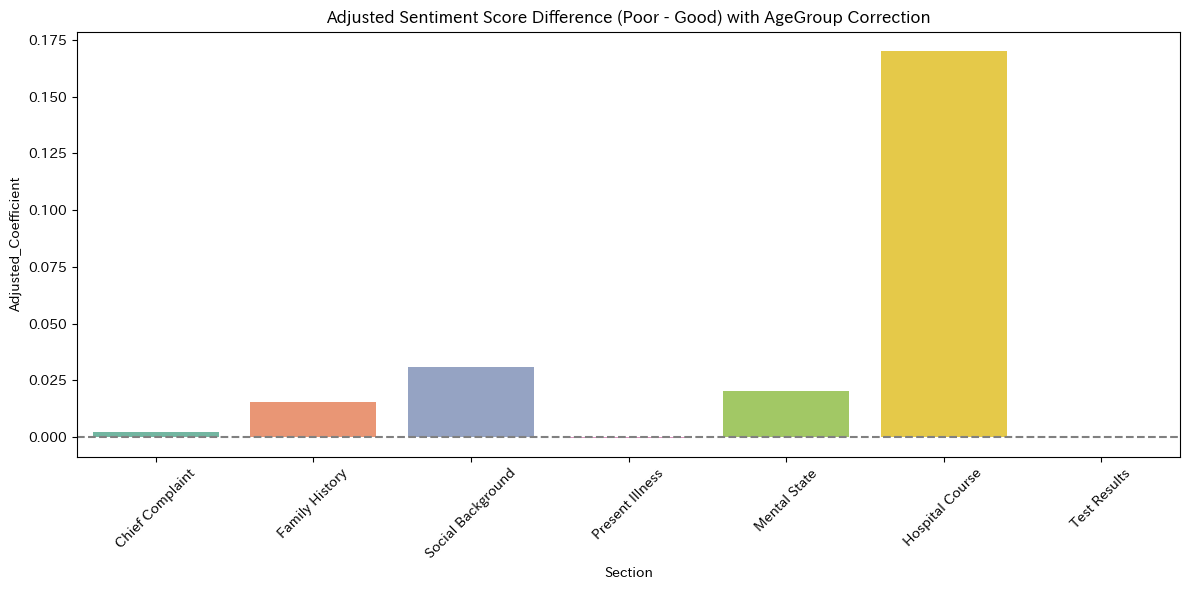


📌 Significant (p<0.05) & Large Effect Size (|d| > 0.5):
Empty DataFrame
Columns: [Section, Adjusted_Coefficient, p_value, Cohens_d]
Index: []


In [81]:
# === セクションごとの分析実行 ===
results = []

for section in sentiment_columns:
    res = compute_adjusted_difference(df, section)
    d = compute_cohens_d(df, section)
    if res:
        coef, pval = res
        results.append({
            'Section': section,
            'Adjusted_Coefficient': coef,
            'p_value': pval,
            'Cohens_d': d
        })

result_df = pd.DataFrame(results)

# === 可視化 ===
if not result_df.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=result_df, x='Section', y='Adjusted_Coefficient', palette='Set2')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('Adjusted Sentiment Score Difference (Poor - Good) with AgeGroup Correction')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 結果が空です。データと前処理をご確認ください。")

# === 有意かつ効果量の大きいものを表示 ===
print("\n📌 Significant (p<0.05) & Large Effect Size (|d| > 0.5):")
print(result_df[(result_df['p_value'] < 0.05) & (result_df['Cohens_d'].abs() > 0.5)])
